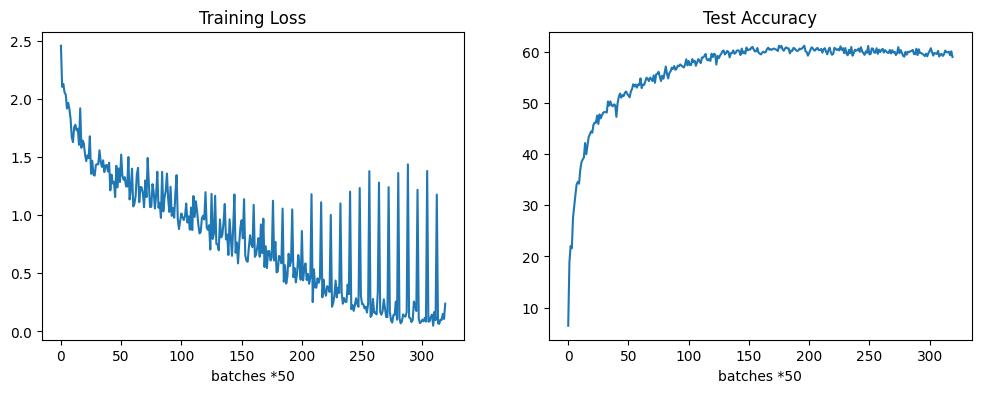

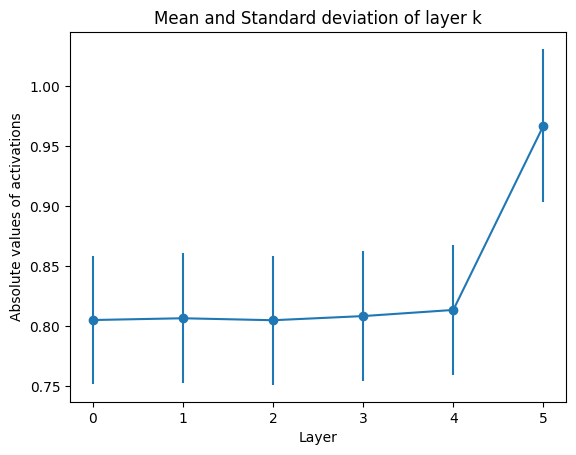

100%|██████████| 40/40 [11:47<00:00, 17.69s/it]


In [3]:
# Code GLONET + VIT
#!pip install matplotlib
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Definition of Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, num_classes=10, dim=128, num_heads=4, num_layers=1, num_glonet=10):
        super(VisionTransformer, self).__init__()

        # We use a feed-forward network for class tokens
        self.class_ffn = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + (32 // 4) * (32 // 4), dim))

        self.patch_embedding = nn.Conv2d(3, dim, 4, stride=4)

        self.transformer_encoders = nn.ModuleList([
            nn.TransformerEncoder(nn.TransformerEncoderLayer(dim, num_heads), num_layers)
            for _ in range(num_glonet)
        ])


        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x).flatten(2).permute(2, 0, 1) # N x C x H x W -> P x N x C
        class_token = self.class_ffn(x.mean(dim=0)).unsqueeze(0) # 1 x N x C
        x = torch.cat([class_token, x], dim=0) # (P + 1) x N x C

        # Extends pos_embedding to combine to batch size
        pos_embedding = self.pos_embedding.repeat(x.shape[1], 1, 1).permute(1, 0, 2)

        x += pos_embedding
        y = 0
        for encoder in self.transformer_encoders:
            x = encoder(x)
            y += x

        return self.fc(x[0])  #cambiato x in y

    def forward_k(self, x, k):
        # k must be greater than the number of transformer_encoders
        k = min(k, len(self.transformer_encoders))

        x = self.patch_embedding(x).flatten(2).permute(2, 0, 1)
        class_token = self.class_ffn(x.mean(dim=0)).unsqueeze(0)
        x = torch.cat([class_token, x], dim=0)

        pos_embedding = self.pos_embedding.repeat(x.shape[1], 1, 1).permute(1, 0, 2)
        x += pos_embedding
        y = 0

        for i in range(k):
            x = self.transformer_encoders[i](x)
            y += x

        return self.fc(y[0])


    def forward_activations(self, x):
        activations = []

        x = self.patch_embedding(x).flatten(2).permute(2, 0, 1)
        class_token = self.class_ffn(x.mean(dim=0)).unsqueeze(0)
        x = torch.cat([class_token, x], dim=0)

        pos_embedding = self.pos_embedding.repeat(x.shape[1], 1, 1).permute(1, 0, 2)
        x += pos_embedding

        for encoder in self.transformer_encoders:
            x = encoder(x)
            activations.append(x)

        return activations


import matplotlib.pyplot as plt

def compute_statistics(activations):
    means = []
    stds = []

    for activation in activations:
        absolute_values = activation.abs()
        means.append(absolute_values.mean().item())
        stds.append(absolute_values.std().item()/np.sqrt(128))

    return means, stds


# load dataset
train_dataset = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

def dataset_to_gpu(dataset):
    # move dataset to gpu for speed-up
    data, labels = zip(*[(d[0], d[1]) for d in dataset])
    data, labels = torch.stack(data), torch.tensor(labels)

    data, labels = data.cuda(), labels.cuda()

    return TensorDataset(data, labels)

train_dataset_gpu = dataset_to_gpu(train_dataset)
test_dataset_gpu = dataset_to_gpu(test_dataset)

train_loader = DataLoader(train_dataset_gpu, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_gpu, batch_size=128)

# Inizializzazione
model = VisionTransformer(num_layers=1, num_glonet=6).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


# Training loop
epochs = 40
for epoch in tqdm(range(epochs)):
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            # accuracy during training
            train_accuracy = (outputs.argmax(dim=1) == y).float().mean()

            # store loss and accuracy
            train_losses.append(loss.item())
            train_accuracies.append(train_accuracy.item())

            # evaluation on test set
            model.eval()
            with torch.no_grad():
                test_loss = 0
                correct = 0
                for x_test, y_test in test_loader:
                    x_test, y_test = x_test.cuda(), y_test.cuda()
                    test_outputs = model(x_test)
                    test_loss += criterion(test_outputs, y_test).item()
                    correct += (test_outputs.argmax(dim=1) == y_test).sum().item()

            test_loss /= len(test_loader)
            test_accuracy = 100. * correct / len(test_loader.dataset)

            # store loss and accuracy of test-set
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)


            clear_output(wait=True)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Training Loss")
    plt.plot(train_losses)
    plt.xlabel('batches *50')

    plt.subplot(1, 2, 2)
    plt.title("Test Accuracy")
    plt.plot(test_accuracies)
    plt.xlabel('batches *50')

    plt.show()

    model.train()

    activations = model.forward_activations(x)

    # compute statistics
    means, stds = compute_statistics(activations)

    layers = range(len(means))
    plt.errorbar(layers, means, yerr=stds, fmt='-o')
    plt.xlabel('Layer')
    plt.ylabel('Absolute values of activations')
    plt.title('Mean and Standard deviation of layer k')
    plt.show()